In [2]:
from utils import balance_sample, univariate_classifier

import numpy as np
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import (
    GridSearchCV,
    train_test_split,
    cross_val_score,
    GroupShuffleSplit,
    permutation_test_score,
    StratifiedKFold,
)
from sklearn.ensemble import ExtraTreesClassifier

from scipy.stats import wilcoxon, mannwhitneyu

# Load Data

In [1]:
epoch_type = 'evoked'
# epoch_type = 'pseudo-rs'

all_participants = ['VP07','VP08','VP09', 'VP10','VP11','VP12','VP13','VP14','VP18','VP19','VP20','VP22','VP23','VP24','VP25','VP26','VP27','VP28','VP29','VP30','VP31','VP32','VP33','VP35','VP36','VP37']

# path = '/media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/' #icm-linux
path = '/Users/nicobruno/ownCloud/MW_eeg_data/minmarker/' #nico-mac

In [3]:
df = pd.DataFrame()

for i,v in enumerate(all_participants): 
    participant = v
    
    folder = path + participant +'/'
    
    df_ = pd.read_csv(folder+ participant + '_' + epoch_type + '_all_marker.csv', index_col = 0)
    df_['participant'] = i
    df = df.append(df_)
    
df.to_csv('all_markers.csv')

In [4]:
df_markers = (df
              .query("stimuli == 'go'")
              .query("correct == 'correct'")
              .query("preproc == 'subtracted'")
            .query('prev_trial <= 4')
              .drop(['stimuli', 'correct', 'prev_trial', 'label', 'events', 'preproc', 'epoch_type'], axis = 1)
              .query("mind in ['on-task','dMW', 'sMW']")
              .groupby(['segment', 'participant']).filter(lambda x: len(x) > 1)
             )

markers = ['wSMI', 'p_e', 'k', 'b', 'b_n', 'g', 'g_n', 't', 't_n',
       'd', 'd_n', 'a_n', 'a', 'CNV', 'P1', 'P3a', 'P3b']

# By Subject Univariate analyses 

## On-task Vs Mind- Wandering
This can only be performed for PC probes  as they are the only ones with On-task reports.

In [5]:
df_mind = (
    df_markers
    .query("probe == 'PC'")
    .assign(
    mind2 = lambda df: np.where(df.mind == 'on-task', 'on-task', 'mw'))
    .groupby(['mind2', 'participant']).filter(lambda x: len(x) > 7) #min nbr of trials
)

agg_dict = {k:['mean', 'std'] for k in markers }
agg_dict.update({k:'first' for k in df_mind.drop(markers, axis=1).columns})

df_mind = (df_mind
    .groupby(['mind2', 'participant'], as_index = False).agg(agg_dict)
#     .query("mind != 'sMW'") #if you want to test against just one of the mw
)

df_mind.columns = df_mind.columns.map("_".join)
df_mind  = df_mind.rename(columns = {'participant_first':'participant', 'probe_first':'probe', 'mind_first':'mind', 'segment_first':'segment', 'mind2_first':'mind2'})
df_mind = balance_sample(df_mind, 'participant', 'mind2', levels = 2).drop(['participant', 'probe', 'mind', 'segment'], axis = 1) # drop mind or mind2 also

AUC wSMI_mean = 0.47916666666666674 WilcoxonResult(statistic=39.0, pvalue=1.0)
AUC wSMI_std = 0.4722222222222222 WilcoxonResult(statistic=28.0, pvalue=0.423828125)
AUC p_e_mean = 0.4930555555555556 WilcoxonResult(statistic=35.0, pvalue=0.791015625)
AUC p_e_std = 0.4097222222222222 WilcoxonResult(statistic=24.0, pvalue=0.26611328125)
AUC k_mean = 0.48611111111111116 WilcoxonResult(statistic=37.0, pvalue=0.90966796875)
AUC k_std = 0.6041666666666666 WilcoxonResult(statistic=35.0, pvalue=0.791015625)
AUC b_mean = 0.5069444444444444 WilcoxonResult(statistic=39.0, pvalue=1.0)
AUC b_std = 0.22916666666666669 WilcoxonResult(statistic=10.0, pvalue=0.02099609375)
AUC b_n_mean = 0.5069444444444444 WilcoxonResult(statistic=37.0, pvalue=0.90966796875)
AUC b_n_std = 0.5347222222222222 WilcoxonResult(statistic=36.0, pvalue=0.85009765625)
AUC g_mean = 0.4930555555555556 WilcoxonResult(statistic=37.0, pvalue=0.90966796875)
AUC g_std = 0.36111111111111116 WilcoxonResult(statistic=25.0, pvalue=0.3012695

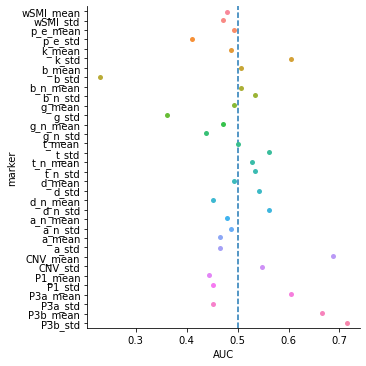

In [6]:
AUC = []
significants = []

for i in df_mind.drop('mind2', axis = 1).columns:
    ot = df_mind.query("mind2 == 'on-task'")[i]
    mw = df_mind.query("mind2 == 'mw'")[i]
    auc = roc_auc_score(df_mind['mind2'], df_mind[i])
    print(f'AUC {i} = {auc}', f'{wilcoxon(x = ot, y = mw)}')
    AUC.append([i, auc])
    if mannwhitneyu(x = ot, y = mw).pvalue < 0.05:
        significants.append(i)

print(f'List of significant markers: {significants}')

subject_mind_roc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])

sns.catplot(x = 'AUC', y = 'marker', data = subject_mind_roc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

AUC wSMI_mean = 0.6597222222222222
AUC wSMI_std = 0.6458333333333333
AUC p_e_mean = 0.611111111111111
AUC p_e_std = 0.6666666666666667
AUC k_mean = 0.5833333333333334
AUC k_std = 0.7361111111111112
AUC b_mean = 0.5763888888888888
AUC b_std = 0.20833333333333334
AUC b_n_mean = 0.7777777777777778
AUC b_n_std = 0.20833333333333334
AUC g_mean = 0.6041666666666667
AUC g_std = 0.3194444444444445
AUC g_n_mean = 0.5902777777777778
AUC g_n_std = 0.6388888888888888
AUC t_mean = 0.5763888888888888
AUC t_std = 0.7291666666666666
AUC t_n_mean = 0.6736111111111112
AUC t_n_std = 0.6458333333333334
AUC d_mean = 0.5694444444444444
AUC d_std = 0.7361111111111112
AUC d_n_mean = 0.6388888888888888
AUC d_n_std = 0.6111111111111112
AUC a_n_mean = 0.5694444444444444
AUC a_n_std = 0.7152777777777778
AUC a_mean = 0.5833333333333334
AUC a_std = 0.5902777777777778
AUC CNV_mean = 0.6909722222222222
AUC CNV_std = 0.6597222222222222
AUC P1_mean = 0.7847222222222222
AUC P1_std = 0.6458333333333334
AUC P3a_mean = 0.7

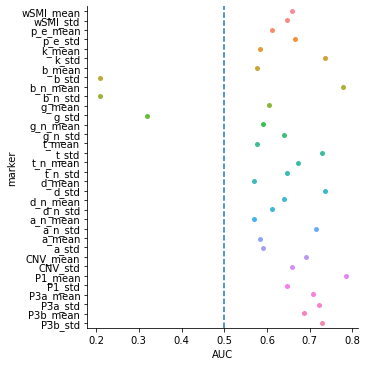

In [7]:
AUC = []
for i in df_mind.drop('mind2', axis = 1).columns:
    y, label = pd.factorize(df_mind['mind2'])
    X = df_mind[i].astype('float32').values.reshape(-1,1)
    svc = SVC(probability=True)
    svc.fit(X, y)
    y_proba = svc.predict_proba(X)
    auc = roc_auc_score(y, y_proba[:,0])
    print(f'AUC {i} = {auc}')
    AUC.append([i, auc])

print(label)
df_auc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])

sns.catplot(x = 'AUC', y = 'marker', data = df_auc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

## dMW Vs sMW
This will be only performed in SC as they have more trials

In [8]:
df_mw = (
    df_markers
    .query("probe == 'SC'")
    .query("mind != 'on-task'")
    .groupby(['mind', 'participant']).filter(lambda x: len(x) > 7) #min nbr of trials
)

agg_dict = {k:'mean' for k in markers }
agg_dict.update({k:'first' for k in df_mw.drop(markers, axis=1).columns})

df_mw = (df_mw
    .groupby(['mind', 'participant'], as_index = False).agg(agg_dict)
)
df_mw = balance_sample(df_mw, 'participant', 'mind', levels = 2).drop(['participant', 'probe','segment'], axis = 1) 


AUC wSMI = 0.55078125 WilcoxonResult(statistic=54.0, pvalue=0.49542236328125)
AUC p_e = 0.484375 WilcoxonResult(statistic=44.0, pvalue=0.231201171875)
AUC k = 0.5390625 WilcoxonResult(statistic=53.0, pvalue=0.4637451171875)
AUC b = 0.5078125 WilcoxonResult(statistic=61.0, pvalue=0.743560791015625)
AUC b_n = 0.515625 WilcoxonResult(statistic=59.0, pvalue=0.668548583984375)
AUC g = 0.515625 WilcoxonResult(statistic=54.0, pvalue=0.49542236328125)
AUC g_n = 0.55078125 WilcoxonResult(statistic=47.0, pvalue=0.2978515625)
AUC t = 0.48046875 WilcoxonResult(statistic=57.0, pvalue=0.596588134765625)
AUC t_n = 0.48828125 WilcoxonResult(statistic=68.0, pvalue=1.0)
AUC d = 0.48046875 WilcoxonResult(statistic=61.0, pvalue=0.743560791015625)
AUC d_n = 0.44140625 WilcoxonResult(statistic=56.0, pvalue=0.5618896484375)
AUC a_n = 0.5 WilcoxonResult(statistic=57.0, pvalue=0.596588134765625)
AUC a = 0.4609375 WilcoxonResult(statistic=56.0, pvalue=0.5618896484375)
AUC CNV = 0.55078125 WilcoxonResult(statist

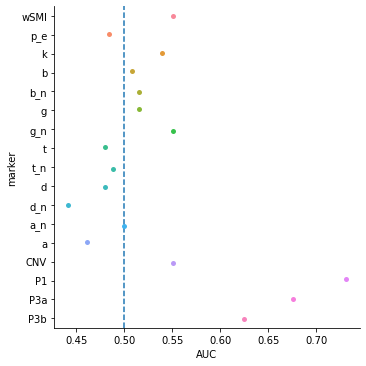

In [9]:
AUC = []
significants = []
for i in df_mw.drop('mind', axis = 1).columns:
    smw = df_mw.query("mind == 'sMW'")[i]
    dmw = df_mw.query("mind == 'dMW'")[i]
    auc = roc_auc_score(df_mw['mind'], df_mw[i])
    print(f'AUC {i} = {auc}', f'{wilcoxon(x = smw, y = dmw)}')
    AUC.append([i, auc])
    if mannwhitneyu(x = smw, y = dmw).pvalue < 0.05:
        significants.append(i)
subject_mw_roc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])

print(f'List of significant markers: {significants}')


sns.catplot(x = 'AUC', y = 'marker', data = subject_mw_roc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

AUC wSMI = 0.6484375
AUC p_e = 0.68359375
AUC k = 0.5625
AUC b = 0.56640625
AUC b_n = 0.60546875
AUC g = 0.5859375
AUC g_n = 0.5625
AUC t = 0.59375
AUC t_n = 0.60546875
AUC d = 0.60546875
AUC d_n = 0.58984375
AUC a_n = 0.59765625
AUC a = 0.62109375
AUC CNV = 0.71875
AUC P1 = 0.5
AUC P3a = 0.29296875
AUC P3b = 0.6796875
Index(['dMW', 'sMW'], dtype='object')


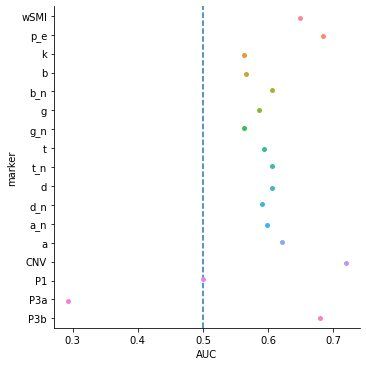

In [10]:
AUC = []
for i in df_mw.drop('mind', axis = 1).columns:
    y, label = pd.factorize(df_mw['mind'])
    X = df_mw[i].astype('float32').values.reshape(-1,1)
    svc = SVC(probability=True)
    svc.fit(X, y)
    y_proba = svc.predict_proba(X)
    auc = roc_auc_score(y, y_proba[:,0])
    print(f'AUC {i} = {auc}')
    AUC.append([i, auc])

print(label)
df_auc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])

sns.catplot(x = 'AUC', y = 'marker', data = df_auc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

# By Segment Univariate analyses

## On-task Vs Mind- Wandering
This can only be performed for PC probes  as they are the only ones with On-task reports.

In [11]:
agg_dict = {k:['mean', 'std'] for k in markers }
agg_dict.update({k:'first' for k in df_markers.drop(markers, axis=1).columns})

df_mind = (
    df_markers
    .query("probe == 'PC'")
    .groupby(['segment', 'participant'], as_index = False).agg(agg_dict)
#     .query("mind != 'sMW'") #if you want to test against just one of the mw
    .assign(
    mind2 = lambda df: np.where(df.mind == 'on-task', 'on-task', 'mw'))
)

df_mind.columns = df_mind.columns.map("_".join)

df_mind  = (df_mind
            .rename(columns = {'participant_first':'participant', 'probe_first':'probe', 'mind_first':'mind', 'segment_first':'segment', 'mind2_':'mind2'})
            .drop(['participant', 'probe', 'mind', 'segment'], axis = 1) 
           )

AUC wSMI_mean = 0.5426829268292682 MannwhitneyuResult(statistic=3525.0, pvalue=0.16496727199686728)
AUC wSMI_std = 0.4807991696938246 MannwhitneyuResult(statistic=3706.0, pvalue=0.330893706671614)
AUC p_e_mean = 0.45524130773222626 MannwhitneyuResult(statistic=3509.0, pvalue=0.1534620293191562)
AUC p_e_std = 0.5311364815775818 MannwhitneyuResult(statistic=3614.0, pvalue=0.238760662076057)
AUC k_mean = 0.4608199273482097 MannwhitneyuResult(statistic=3552.0, pvalue=0.18561487819637795)
AUC k_std = 0.5880254281266216 MannwhitneyuResult(statistic=3175.5, pvalue=0.022174713595810497)
AUC b_mean = 0.425531914893617 MannwhitneyuResult(statistic=3280.0, pvalue=0.04448537842954947)
AUC b_std = 0.4708095485210171 MannwhitneyuResult(statistic=3629.0, pvalue=0.25276668357256504)
AUC b_n_mean = 0.4316294758692268 MannwhitneyuResult(statistic=3327.0, pvalue=0.05920735222512055)
AUC b_n_std = 0.5281525687597302 MannwhitneyuResult(statistic=3637.0, pvalue=0.2604097109316945)
AUC g_mean = 0.45731707317

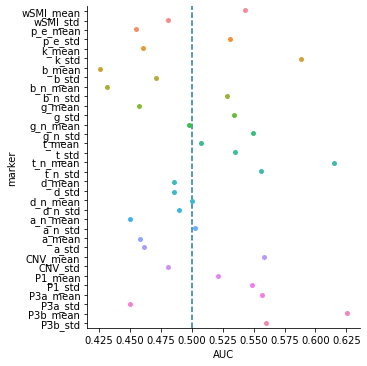

In [12]:
significants = []
AUC = []
for i in df_mind.drop('mind2', axis = 1).columns:
    ot = df_mind.query("mind2 == 'on-task'")[i]
    mw = df_mind.query("mind2 == 'mw'")[i]
    auc = roc_auc_score(df_mind['mind2'], df_mind[i])
    print(f'AUC {i} = {auc}', f'{mannwhitneyu(x = ot, y = mw)}')
    AUC.append([i, auc])
    if mannwhitneyu(x = ot, y = mw).pvalue < 0.05:
        significants.append([i, auc])
        
segment_mind_roc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])
significants_mind = pd.DataFrame(significants, columns = ['marker', 'AUC'])

print(f'List of significant markers: {significants_mind.marker.values}')

sns.catplot(x = 'AUC', y = 'marker', data = segment_mind_roc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

AUC wSMI_mean = 0.5208024691358024
p_value = 0.36563436563436563


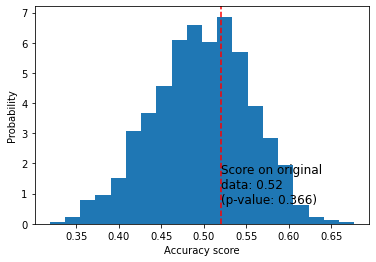

AUC wSMI_std = 0.4930555555555555
p_value = 0.5454545454545454


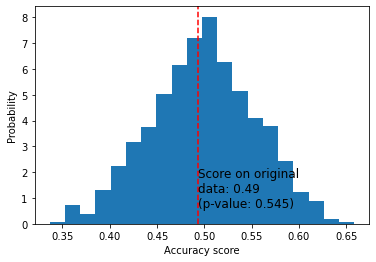

AUC p_e_mean = 0.42834876543209877
p_value = 0.8861138861138861


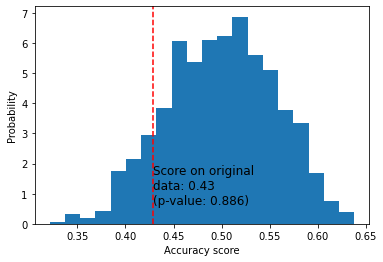

AUC p_e_std = 0.5474074074074073
p_value = 0.23576423576423577


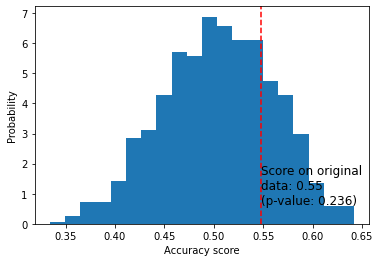

AUC k_mean = 0.4606172839506173
p_value = 0.7502497502497503


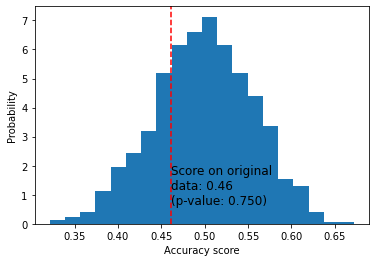

AUC k_std = 0.6031172839506173
p_value = 0.026973026973026972


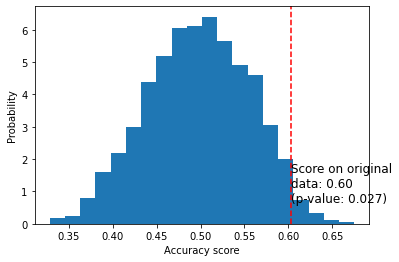

AUC b_mean = 0.5880401234567901
p_value = 0.06493506493506493


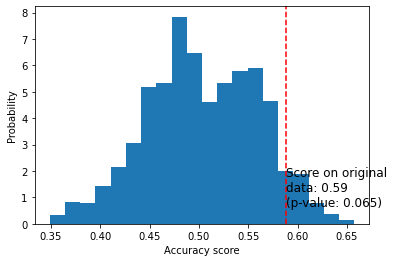

AUC b_std = 0.4687654320987654
p_value = 0.7022977022977023


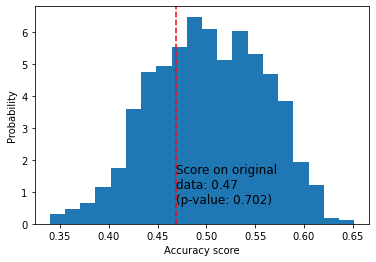

AUC b_n_mean = 0.5607716049382716
p_value = 0.13886113886113885


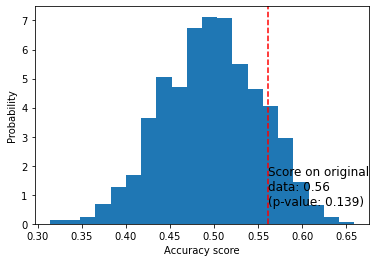

AUC b_n_std = 0.5244290123456791
p_value = 0.36363636363636365


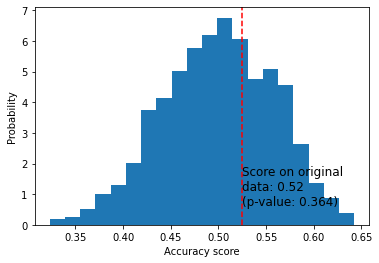

AUC g_mean = 0.3911111111111111
p_value = 0.962037962037962


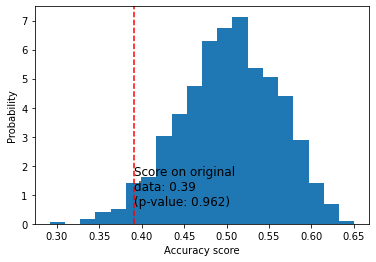

AUC g_std = 0.42712962962962964
p_value = 0.9000999000999002


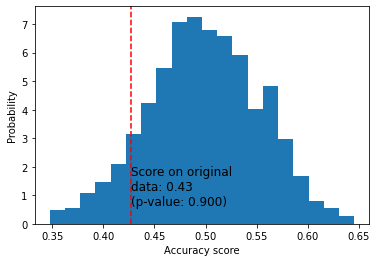

AUC g_n_mean = 0.49103395061728394
p_value = 0.5894105894105894


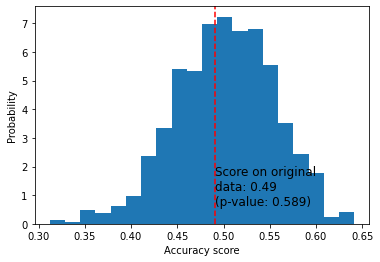

AUC g_n_std = 0.5363271604938271
p_value = 0.26073926073926074


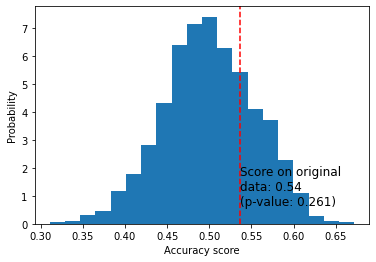

AUC t_mean = 0.5233950617283951
p_value = 0.3336663336663337


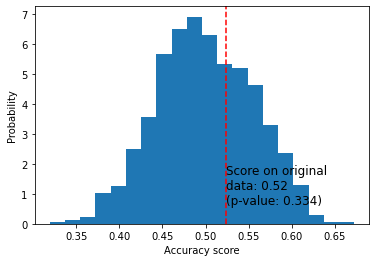

AUC t_std = 0.4724691358024692
p_value = 0.6813186813186813


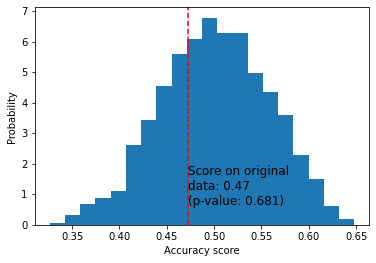

AUC t_n_mean = 0.6281327160493827
p_value = 0.005994005994005994


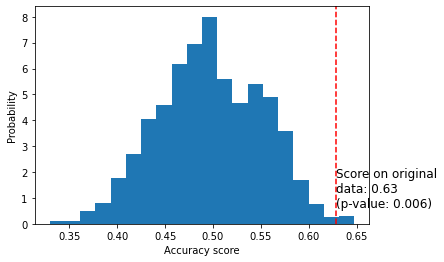

AUC t_n_std = 0.5792901234567901
p_value = 0.07492507492507493


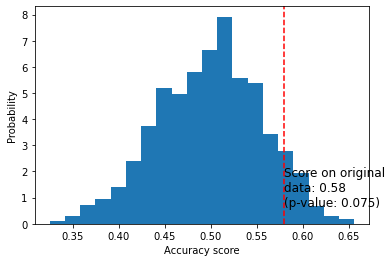

AUC d_mean = 0.43075617283950624
p_value = 0.9120879120879121


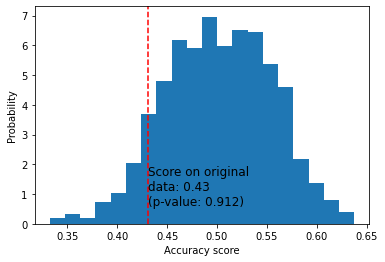

AUC d_std = 0.4775925925925926
p_value = 0.6593406593406593


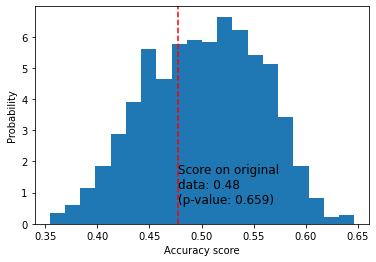

AUC d_n_mean = 0.5230401234567902
p_value = 0.35064935064935066


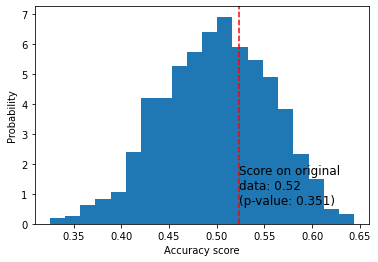

AUC d_n_std = 0.520354938271605
p_value = 0.3936063936063936


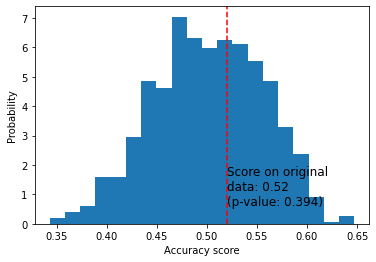

AUC a_n_mean = 0.47533950617283943
p_value = 0.6343656343656343


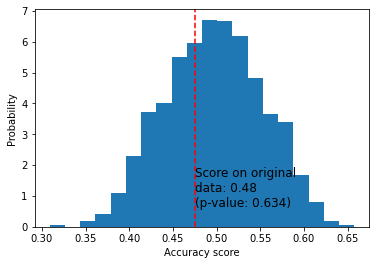

AUC a_n_std = 0.4520833333333334
p_value = 0.8041958041958042


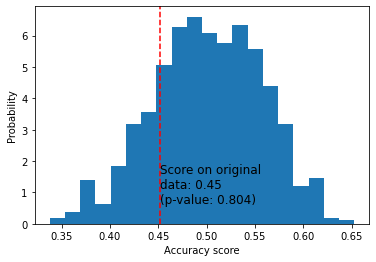

AUC a_mean = 0.5300308641975309
p_value = 0.3106893106893107


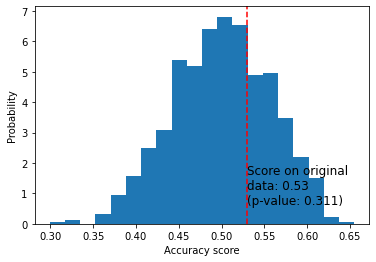

AUC a_std = 0.5496296296296296
p_value = 0.1958041958041958


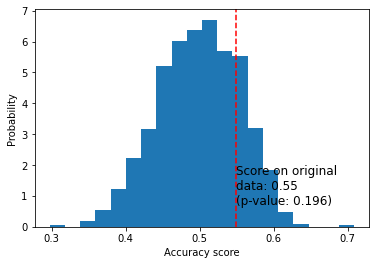

AUC CNV_mean = 0.5358796296296297
p_value = 0.2627372627372627


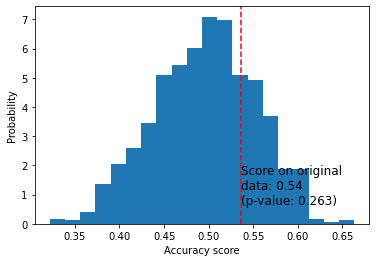

AUC CNV_std = 0.4759722222222223
p_value = 0.6843156843156843


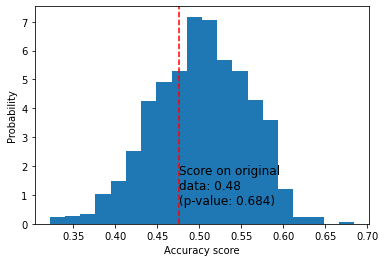

AUC P1_mean = 0.4298611111111111
p_value = 0.8891108891108891


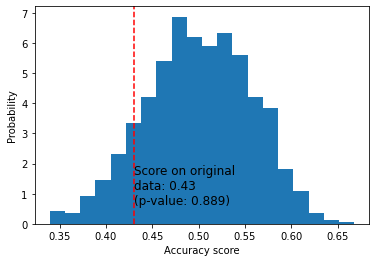

AUC P1_std = 0.42305555555555563
p_value = 0.9170829170829171


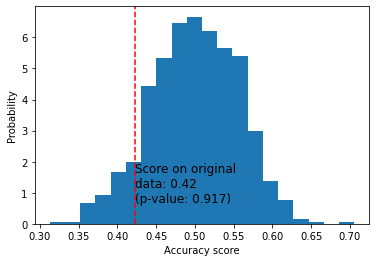

AUC P3a_mean = 0.5355401234567903
p_value = 0.2837162837162837


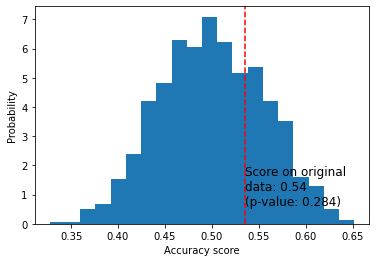

AUC P3a_std = 0.4920833333333333
p_value = 0.5644355644355644


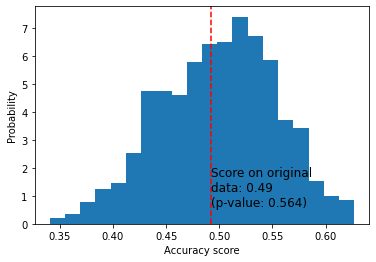

AUC P3b_mean = 0.6186265432098766
p_value = 0.00999000999000999


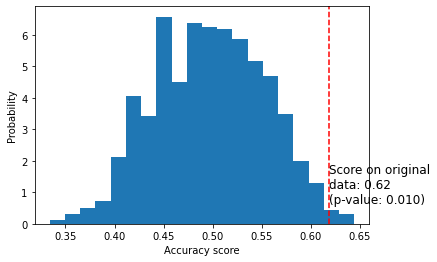

AUC P3b_std = 0.5026543209876544
p_value = 0.47052947052947053


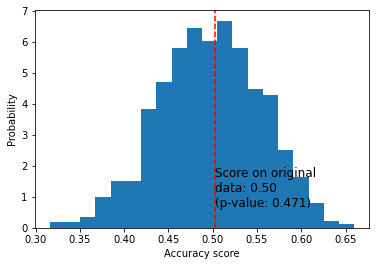

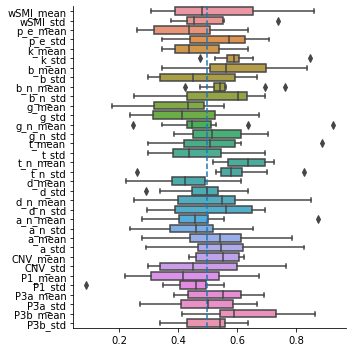

In [119]:
AUC = pd.DataFrame()
for i in df_mind.drop('mind2', axis = 1).columns:
    

    AUC[i] =  univariate_classifier(
    data= df_mind, label = 'mind2', feature = i, model = 'SVM', grid_search=False, permutation=True, n_permutations = 100
)

    
sns.catplot(data = AUC, kind = 'box', orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

In [ ]:
n_estimators = 2000
AUC = pd.DataFrame()
for i in df_mind.drop('mind2', axis = 1).columns:
    
    y, label = pd.factorize(df_mind['mind2'])
    X = df_mind[i].astype('float32').values.reshape(-1,1)
    
    doc_forest = make_pipeline(
        RobustScaler(),
        ExtraTreesClassifier(
            n_estimators=n_estimators, max_features=1, criterion='entropy',
            max_depth=4, random_state=42, class_weight='balanced'))

    cv = GroupShuffleSplit(n_splits=50, train_size=0.8, test_size=0.2,
                           random_state=42)

    aucs = cross_val_score(
        X=X, y=y, estimator=doc_forest,
        scoring='roc_auc', cv=cv, groups=np.arange(len(X)))

    AUC[i] = aucs

#     print(label)
    print(f'AUC {i} = {np.mean(aucs)}')

In [ ]:
sns.catplot(data = AUC, kind = 'box', orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

## dMW Vs sMW
This will be only performed in SC as they have more trials

In [8]:
agg_dict = {k:['mean', 'std'] for k in markers }
agg_dict.update({k:'first' for k in df_markers.drop(markers, axis=1).columns})

df_mw = (
    df_markers
    .query("probe == 'SC'")
    .query("mind != 'on-task'")
    .groupby(['segment', 'participant'], as_index = False).agg(agg_dict)
)

df_mw.columns = df_mw.columns.map("_".join)

df_mw  = (df_mw
            .rename(columns = {'participant_first':'participant', 'probe_first':'probe', 'mind_first':'mind', 'segment_first':'segment'})
            .drop(['participant', 'probe', 'segment'], axis = 1) 
           )

AUC wSMI_mean = 0.46748251748251746 MannwhitneyuResult(statistic=33425.0, pvalue=0.09688428493426793)
AUC wSMI_std = 0.4836783216783217 MannwhitneyuResult(statistic=34583.0, pvalue=0.25715816083766774)
AUC p_e_mean = 0.37370629370629366 MannwhitneyuResult(statistic=26720.0, pvalue=2.2329998043768022e-07)
AUC p_e_std = 0.5151468531468532 MannwhitneyuResult(statistic=34667.0, pvalue=0.2725325727848976)
AUC k_mean = 0.5012797202797203 MannwhitneyuResult(statistic=35658.5, pvalue=0.47971311694161795)
AUC k_std = 0.5130419580419581 MannwhitneyuResult(statistic=34817.5, pvalue=0.3011713086159559)
AUC b_mean = 0.4229370629370629 MannwhitneyuResult(statistic=30240.0, pvalue=0.001034708988537611)
AUC b_std = 0.4616643356643356 MannwhitneyuResult(statistic=33009.0, pvalue=0.062751859734307)
AUC b_n_mean = 0.48141258741258736 MannwhitneyuResult(statistic=34421.0, pvalue=0.2288323928485717)
AUC b_n_std = 0.4746013986013986 MannwhitneyuResult(statistic=33934.0, pvalue=0.15506368106423052)
AUC g_mea

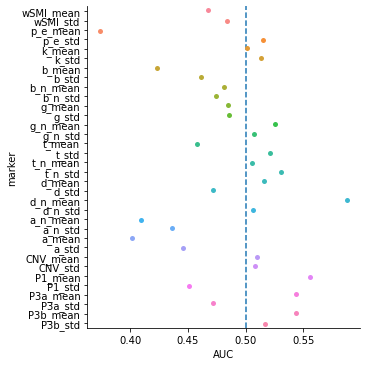

In [9]:
AUC = []
significants = []
for i in df_mw.drop('mind', axis = 1).columns:
    smw = df_mw.query("mind == 'sMW'")[i]
    dmw = df_mw.query("mind == 'dMW'")[i]
    auc = roc_auc_score(df_mw['mind'], df_mw[i])
    print(f'AUC {i} = {auc}', f'{mannwhitneyu(x = smw, y = dmw)}')
    AUC.append([i, auc])
    if mannwhitneyu(x = smw, y = dmw).pvalue < 0.05:
        significants.append([i, auc])
segment_mw_roc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])
significants_mw = pd.DataFrame(significants, columns = ['marker', 'AUC'])

print(f'List of significant markers: {significants_mw.marker.values}')

sns.catplot(x = 'AUC', y = 'marker', data = segment_mw_roc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

AUC wSMI_mean = 0.47657635467980286
p_value = 0.7782217782217782
AUC wSMI_std = 0.5254679802955665
p_value = 0.2087912087912088
AUC p_e_mean = 0.6340886699507389
p_value = 0.000999000999000999
AUC p_e_std = 0.5177142857142856
p_value = 0.26173826173826176
AUC k_mean = 0.5015492610837439
p_value = 0.4945054945054945
AUC k_std = 0.5096896551724138
p_value = 0.3706293706293706
AUC b_mean = 0.5803793103448276
p_value = 0.004995004995004995
AUC b_std = 0.5412660098522168
p_value = 0.055944055944055944
AUC b_n_mean = 0.5029704433497536
p_value = 0.4725274725274725
AUC b_n_std = 0.48229064039408864
p_value = 0.7242757242757243
AUC g_mean = 0.4656305418719212
p_value = 0.8891108891108891
AUC g_std = 0.502768472906404
p_value = 0.45054945054945056
AUC g_n_mean = 0.5233448275862069
p_value = 0.22477522477522477
AUC g_n_std = 0.5086108374384237
p_value = 0.3956043956043956
AUC t_mean = 0.5648669950738917
p_value = 0.011988011988011988
AUC t_std = 0.4870443349753694
p_value = 0.6793206793206793
AU

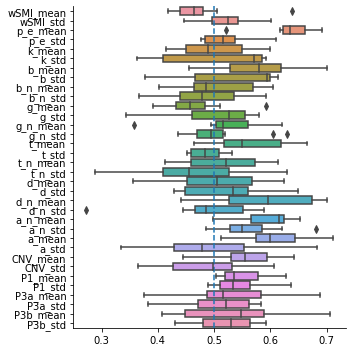

In [7]:
AUC = pd.DataFrame()
for i in df_mw.drop('mind', axis = 1).columns:
    

    AUC[i] =  univariate_classifier(
    data= df_mw, label = 'mind', feature = i, model = 'SVM', grid_search=False, permutation=True, n_permutations = 100
)

    
sns.catplot(data = AUC, kind = 'box', orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

# By Trial Univariate analyses

## On-task Vs Mind- Wandering
This can only be performed for PC probes  as they are the only ones with On-task reports.

In [10]:
agg_dict = {k:'mean' for k in markers }
agg_dict.update({k:'first' for k in df_markers.drop(markers, axis=1).columns})

df_mind = (
    df_markers
    .query("probe == 'PC'")
#     .query("mind != 'sMW'") #if you want to test against just one of the mw
    .assign(
    mind2 = lambda df: np.where(df.mind == 'on-task', 'on-task', 'mw'))
    .drop(['participant', 'probe', 'mind', 'segment'], axis = 1) # drop mind or mind2 also
)

In [11]:
significants = []
AUC = []
for i in df_mind.drop('mind2', axis = 1).columns:
    ot = df_mind.query("mind2 == 'on-task'")[i]
    mw = df_mind.query("mind2 == 'mw'")[i]
    auc = roc_auc_score(df_mind['mind2'], df_mind[i])
    print(f'AUC {i} = {auc}', f'{mannwhitneyu(x = ot, y = mw)}')
    AUC.append([i, auc])
    if mannwhitneyu(x = ot, y = mw).pvalue < 0.05:
        significants.append(i)

print(f'List of significant markers: {significants}')

trial_mind_roc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])

sns.catplot(x = 'AUC', y = 'marker', data = trial_mind_roc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

AUC wSMI = 0.5258999815658494 MannwhitneyuResult(statistic=36006.0, pvalue=0.14681018084443087)
AUC p_e = 0.47246727938271926 MannwhitneyuResult(statistic=35882.0, pvalue=0.13211798005505238)
AUC k = 0.4776617596713454 MannwhitneyuResult(statistic=36276.5, pvalue=0.18253238159284724)
AUC b = 0.4386801148184236 MannwhitneyuResult(statistic=33316.0, pvalue=0.006444680745797501)
AUC b_n = 0.43046375055960817 MannwhitneyuResult(statistic=32692.0, pvalue=0.002400734190016988)
AUC g = 0.4739946804308325 MannwhitneyuResult(statistic=35998.0, pvalue=0.1458304511935839)
AUC g_n = 0.5048455481526347 MannwhitneyuResult(statistic=37605.0, pvalue=0.4222017711217257)
AUC t = 0.4961156611276434 MannwhitneyuResult(statistic=37678.0, pvalue=0.43751279199662496)
AUC t_n = 0.5666789561003871 MannwhitneyuResult(statistic=32909.0, pvalue=0.0034237551551522813)
AUC d = 0.4786690543280752 MannwhitneyuResult(statistic=36353.0, pvalue=0.19354774425159538)
AUC d_n = 0.5004476865141021 MannwhitneyuResult(statist

NameError: name 'segment_mind_roc' is not defined

AUC wSMI = 0.4984022988505747
p_value = 0.5444555444555444
AUC p_e = 0.4901211317418214
p_value = 0.6093906093906094
AUC k = 0.5052061892130858
p_value = 0.4275724275724276
AUC b = 0.55764350132626
p_value = 0.016983016983016984
AUC b_n = 0.5590843501326261
p_value = 0.013986013986013986
AUC g = 0.4571798408488063
p_value = 0.945054945054945
AUC g_n = 0.46338638373121127
p_value = 0.8831168831168831
AUC t = 0.4609236074270557
p_value = 0.936063936063936
AUC t_n = 0.48273492484526975
p_value = 0.6973026973026973
AUC d = 0.5066611847922193
p_value = 0.3866133866133866
AUC d_n = 0.5275541998231653
p_value = 0.17882117882117882
AUC a_n = 0.5095381078691423
p_value = 0.36863136863136864
AUC a = 0.49582670203359863
p_value = 0.5114885114885115
AUC CNV = 0.49237506631299743
p_value = 0.5854145854145855
AUC P1 = 0.4739352785145889
p_value = 0.8241758241758241
AUC P3a = 0.526027409372237
p_value = 0.17482517482517482
AUC P3b = 0.5313946949602122
p_value = 0.13286713286713286


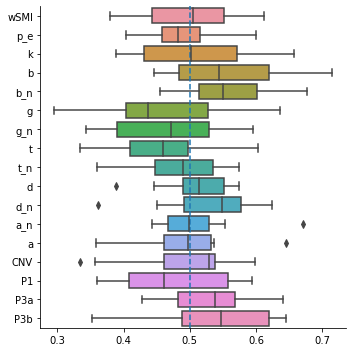

In [12]:
AUC = pd.DataFrame()
for i in df_mind.drop('mind2', axis = 1).columns:
    

    AUC[i] =  univariate_classifier(
    data= df_mind, label = 'mind2', feature = i, model = 'SVM', grid_search=False, permutation=True, n_permutations = 100
)

    
sns.catplot(data = AUC, kind = 'box', orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

In [ ]:
n_estimators = 2000
AUC = pd.DataFrame()
for i in  df_mind.drop('mind2', axis = 1).columns:
    
    y, label = pd.factorize(df_mind['mind2'])
    X = df_mind[i].astype('float32').values.reshape(-1,1)
    
    doc_forest = make_pipeline(
        RobustScaler(),
        ExtraTreesClassifier(
            n_estimators=n_estimators, max_features=1, criterion='entropy',
            max_depth=4, random_state=42, class_weight='balanced'))

    cv = GroupShuffleSplit(n_splits=50, train_size=0.8, test_size=0.2,
                           random_state=42)

    aucs = cross_val_score(
        X=X, y=y, estimator=doc_forest,
        scoring='roc_auc', cv=cv, groups=np.arange(len(X)))

    AUC[i] = aucs

#     print(label)
    print(f'AUC {i} = {np.mean(aucs)}')

sns.catplot(data = AUC, kind = 'box', orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

## dMW Vs sMW
This will be only performed in SC as they have more trials

In [13]:
df_mw = (
    df_markers
    .query("probe == 'SC'")
    .query("mind != 'on-task'")
    .drop(['participant', 'probe', 'segment'], axis = 1)
)

AUC wSMI = 0.4860704229705045 MannwhitneyuResult(statistic=298822.0, pvalue=0.17007120658373165)
AUC p_e = 0.4061772594998788 MannwhitneyuResult(statistic=249706.0, pvalue=6.584398184006263e-11)
AUC k = 0.5052190165118393 MannwhitneyuResult(statistic=304177.0, pvalue=0.3604114293415178)
AUC b = 0.4343438451065519 MannwhitneyuResult(statistic=267022.0, pvalue=3.45768938605754e-06)
AUC b_n = 0.4848049110969776 MannwhitneyuResult(statistic=298044.0, pvalue=0.14904222693430863)
AUC g = 0.48547670596043085 MannwhitneyuResult(statistic=298457.0, pvalue=0.15997918402886419)
AUC g_n = 0.5280730548448122 MannwhitneyuResult(statistic=290127.0, pvalue=0.02727319208515038)
AUC t = 0.46651842718670855 MannwhitneyuResult(statistic=286802.0, pvalue=0.010927925013789041)
AUC t_n = 0.5080818711357563 MannwhitneyuResult(statistic=302417.0, pvalue=0.28998953192640525)
AUC d = 0.5162296204603015 MannwhitneyuResult(statistic=297408.0, pvalue=0.13319857130204305)
AUC d_n = 0.5669151602791933 MannwhitneyuRes

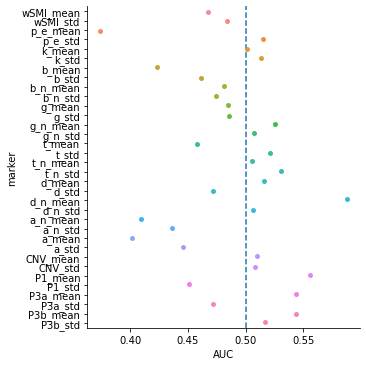

In [14]:
AUC = []
significants = []
for i in df_mw.drop('mind', axis = 1).columns:
    smw = df_mw.query("mind == 'sMW'")[i]
    dmw = df_mw.query("mind == 'dMW'")[i]
    auc = roc_auc_score(df_mw['mind'], df_mw[i])
    print(f'AUC {i} = {auc}', f'{mannwhitneyu(x = smw, y = dmw)}')
    AUC.append([i, auc])
    if mannwhitneyu(x = smw, y = dmw).pvalue < 0.05:
        significants.append(i)
trial_mw_roc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])

print(f'List of significant markers: {significants}')

sns.catplot(x = 'AUC', y = 'marker', data = segment_mw_roc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

AUC wSMI = 0.4956452766223113
p_value = 0.6123876123876124
AUC p_e = 0.5939270028633444
p_value = 0.000999000999000999
AUC k = 0.4903452489844512
p_value = 0.7332667332667333
AUC b = 0.5869333123845614
p_value = 0.000999000999000999
AUC b_n = 0.502222895452146
p_value = 0.4755244755244755
AUC g = 0.5077544912818885
p_value = 0.3066933066933067
AUC g_n = 0.5307087477716003
p_value = 0.01998001998001998
AUC t = 0.546150492036874
p_value = 0.003996003996003996
AUC t_n = 0.5058369578857088
p_value = 0.35664335664335667
AUC d = 0.5013734175639895
p_value = 0.4805194805194805
AUC d_n = 0.5658276839058466
p_value = 0.000999000999000999
AUC a_n = 0.5704771549493548
p_value = 0.000999000999000999
AUC a = 0.5886680521894059
p_value = 0.000999000999000999
AUC CNV = 0.49634388964767695
p_value = 0.6123876123876124
AUC P1 = 0.4974086965404451
p_value = 0.5824175824175825
AUC P3a = 0.5178315817256187
p_value = 0.12187812187812187
AUC P3b = 0.553697082313118
p_value = 0.000999000999000999


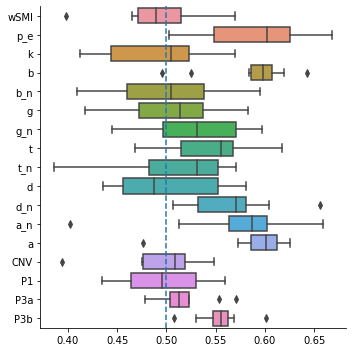

In [15]:
AUC = pd.DataFrame()
for i in df_mw.drop('mind', axis = 1).columns:
    

    AUC[i] =  univariate_classifier(
    data= df_mw, label = 'mind', feature = i, model = 'SVM', grid_search=False, permutation=True, n_permutations = 100
)

    
sns.catplot(data = AUC, kind = 'box', orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

# Plots

## On-task Vs Mind- Wandering
This can only be performed for PC probes  as they are the only ones with On-task reports.

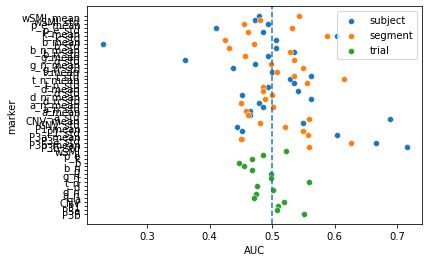

In [135]:
sns.scatterplot(x = 'AUC', y = 'marker', data = subject_mind_roc)
sns.scatterplot(x = 'AUC', y = 'marker', data = segment_mind_roc)
sns.scatterplot(x = 'AUC', y = 'marker', data = trial_mind_roc)
plt.legend(['subject','segment', 'trial'])
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

## dMW Vs sMW
This will be only performed in SC as they have more trials

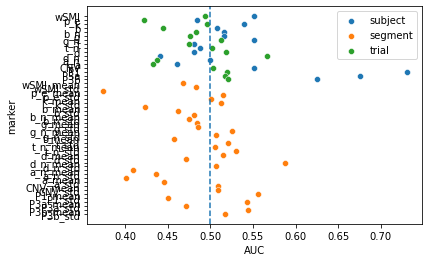

In [136]:
sns.scatterplot(x = 'AUC', y = 'marker', data = subject_mw_roc)
sns.scatterplot(x = 'AUC', y = 'marker', data = segment_mw_roc)
sns.scatterplot(x = 'AUC', y = 'marker', data = trial_mw_roc)
plt.legend(['subject','segment', 'trial'])
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

## Comparison of significan markers for Mind and Mw

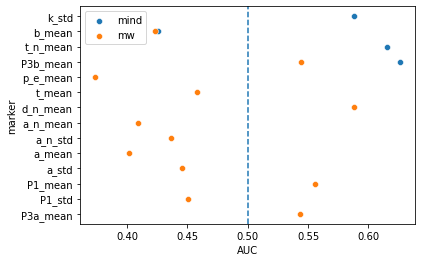

In [134]:
sns.scatterplot(x = 'AUC', y = 'marker', data = significants_mind )
sns.scatterplot(x = 'AUC', y = 'marker', data = significants_mw )
plt.legend(['mind','mw'])
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()